# MLFlow runs

In [66]:
import mlflow

mlflow.tracking.set_tracking_uri('../mlruns')

## Functions

In [2]:
def get_runs(experiment_name, filter_string=''):
    client = MlflowClient()
    exp_ids = [client.get_experiment_by_name(experiment_name).experiment_id]
    runs = mlflow.search_runs(experiment_ids=exp_ids, filter_string=filter_string)
    return runs


def get_best_run(runs, best_metrics):
    if runs is None or runs.shape[0] == 0:
        return None
    for metric in best_metrics:
        runs = runs.loc[runs[f'metrics.{metric}'] >= runs[f'metrics.{metric}'].max()]
    # pick first in the list
    run = runs.loc[runs.index[0]]
    return run

In [3]:
def runs_to_latex(runs, threshold_method, caption, label, grouped=False):
    cols = ['tags.mlflow.runName', 'tags.model', 'tags.method', 'metrics.test_auc', 'metrics.test_tax_yield', 'metrics.test_tax_score', 'metrics.test_effort', 'metrics.test_f1-score_1', 'metrics.test_recall_1', 'metrics.test_precision_1', 'metrics.threshold']
    cols_renamed = [ 'name', 'model', 'method', 'auc', 'yield', 'value', 'effort', 'f1-score', 'recall', 'precision', 'threshold' ]
    to_replace = {
        'model': {'tree': 'DT', 'forest': 'RF', 'logit': 'LR'},
        'method': {'imbalanced': 'IM', 'oversample': 'RO', 'weighted': 'BC'}}
    df = runs.loc[:, :]
    df = df.loc[df['tags.threshold_method']==threshold_method]
    df = df.loc[df['tags.grouped']==str(grouped)]
    df = df.sort_index(ascending=False)
    df = df.loc[:, cols]
    df = df.rename(columns=dict(zip(cols, cols_renamed)))
    df = df.replace(to_replace=to_replace)
    df.loc[:, 'name'] = df.model.str.cat(df.method, sep='-')
    df = df.drop(columns=['model', 'method']).set_index(['name'])
    if threshold_method=='default':
        df = df.drop(columns=['threshold'])
    else:
        df = df.drop(columns=['auc'])
    cols_max = df.columns.drop('effort').tolist()
    s = df.style.highlight_max(subset=cols_max, axis=0, props='bfseries: ;')
    s = s.highlight_min(subset='effort', axis=0, props='bfseries: ;')
    latex_table = s.to_latex(
        column_format="lrrrrrrr", position="ht", position_float="centering",
        hrules=True, label=label, caption=caption,
        multirow_align="t", multicol_align="r")
    return latex_table

In [138]:
import matplotlib.pyplot as plt
import os, json

def get_mlflow_boxacc_prcurve(experiment_name = 'wsol2', dataset='SYNTHETIC', spec='o1b', archtype='cam'):
    boxacc = {}
    prcurve = {}
    iou_thresholds = [30, 50, 70]
    filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED" and tags.architecture_type = "{archtype}"'
    runs = get_runs(experiment_name, filter_string=filter_string)
    if spec:
        background_filter = spec
        runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

    for row in runs.itertuples(index=False):
        artifact_uri = row.artifact_uri
        artifact_path = artifact_uri[len('file://'):]
        config_path = os.path.join(artifact_path, 'state/config.json')
        with open(config_path) as fp:
            _config = json.load(fp)
        boxacc[_config['wsol_method']] = {}
        for iou_threshold in iou_thresholds:
            boxacc_path = os.path.join(artifact_path, f'data/test/box_acc_iou_{iou_threshold}.json')
            with open(boxacc_path) as fp:
                _boxacc = json.load(fp)
                values = {k: _boxacc[k] for k in ['cam_threshold', 'box_accuracy']}
                boxacc[_config['wsol_method']][iou_threshold] = values
        prcurve_path = os.path.join(artifact_path, 'data/test/pr_curve.json')
        with open(prcurve_path) as fp:
            # _prcurve = json.load(fp)
            # values = {k: _prcurve[k] for k in ['precision', 'recall']}
            prcurve[_config['wsol_method']] = json.load(fp)
    return boxacc, prcurve

def plot_boxacc(boxacc, title, iou_thresholds=None):
    # plot lines
    if iou_thresholds is None:
        iou_thresholds = [30, 50, 70]
    for method, iou_values in boxacc.items():
        for iou_threshold, values in iou_values.items():
            if iou_threshold not in iou_thresholds:
                continue
            x = np.asarray(values['cam_threshold'])
            y = np.asarray(values['box_accuracy'])
            xmax = x[np.argmax(y)]
            ymax = y.max()
            label = method if len(iou_thresholds) == 1 else f'{method} {iou_threshold}'
            plt.plot(x, y, label=label)
            plt.plot(xmax, ymax, 'ro')
            text= f"({xmax:.2f}, {ymax:.2f})"
            plt.text(xmax + 0.01, ymax + 0.01, text)
    plt.xlabel("CAM threshold")
    plt.ylabel("BoxAcc")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

def plot_prcurve(curve, title):
    # plot lines
    for method, values in curve.items():
        label = f"{method} (auc {values['auc']:.2f})"
        plt.plot(values['recall'], values['precision'], label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim((-0.05, 1.05))
    plt.ylim((-0.05, 1.05))
    plt.title(title)
    plt.legend()
    plt.show()

## Reports

In [50]:
experiment_name = 'wsol_resnet50_synthetic'
dataset = 'SYNTHETIC'
architecture = 'resnet50'
architecture_type = None#'cam'
background_filter = 't'

### MaxBoxAccV3 and PxAP

In [51]:
filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED"'
if architecture_type:
    filter_string += f'and tags.architecture_type = "{architecture_type}"'
runs = get_runs(experiment_name, filter_string=filter_string)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [52]:
cols = ['tags.mlflow.runName', 'metrics.test_MaxBoxAccV3', 'metrics.test_PxAP']

In [53]:
runs2 = runs.loc[:, cols].sort_values(by='tags.mlflow.runName')

In [54]:
print(runs2.loc[:,['tags.mlflow.runName','metrics.test_MaxBoxAccV3']])

          tags.mlflow.runName  metrics.test_MaxBoxAccV3
0  resnet50_cam_synthetic_o1t                  0.676667


In [55]:
print(runs2.loc[:,['tags.mlflow.runName','metrics.test_PxAP']])

          tags.mlflow.runName  metrics.test_PxAP
0  resnet50_cam_synthetic_o1t            0.65901


### Localization performance at varying CAM thresholds

In [56]:
path_basedir = '../train_log'
methods = ['cam', 'gradcam', 'scorecam', 'minmaxcam']
background_filter = 'o1t'

In [57]:
filter_string = f'tags.dataset = "{dataset}" and status = "FINISHED"'
if architecture_type:
    filter_string += f'and tags.architecture_type = "{architecture_type}"'
runs = get_runs(experiment_name, filter_string=filter_string)
runs = runs.loc[runs['tags.dataset_spec'].str.contains(background_filter)]

In [58]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_loss,metrics.val_MaxBoxAccV3_IOU_50,metrics.train_loss,metrics.train_accuracy,...,tags.train,tags.pretrained,tags.mlflow.runName,tags.num_classes,tags.model,tags.dataset,tags.optimizer,tags.dataset_spec,tags.architecture,tags.large_feature_map
0,63fa71e18f4849a19f49b2923adf57a3,965153792060422881,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-23 12:30:16.687000+00:00,2023-02-23 12:56:11.223000+00:00,0.053256,0.825,0.004829,1.0,...,True,True,resnet50_cam_synthetic_o1t,9,ResNetCam,SYNTHETIC,SGD,o1t,resnet50,False


In [59]:
runs.loc[:, ['tags.method', 'tags.architecture', 'tags.dataset', 'tags.dataset_spec', 'artifact_uri']]

,tags.method,tags.architecture,tags.dataset,tags.dataset_spec,artifact_uri
0,cam,resnet50,SYNTHETIC,o1t,file:///Users/goemaereg/github.com/thesis/mlru...


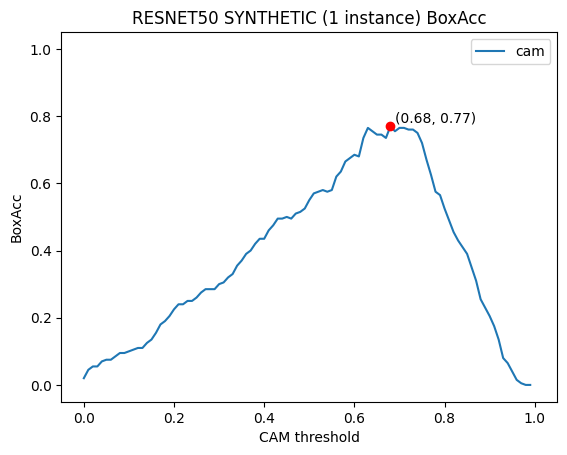

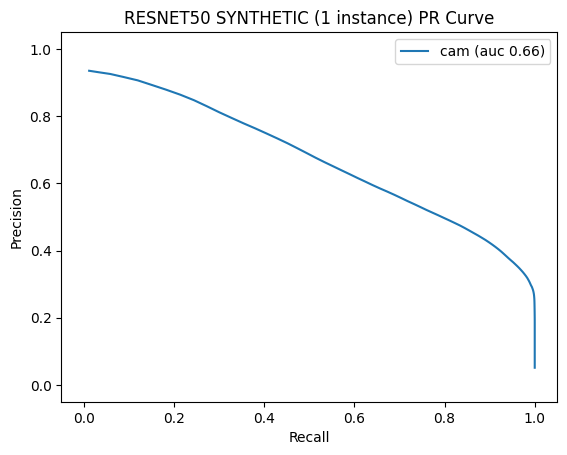

In [139]:
for i in range(1):
    instances = i + 1
    spec = f"{'b' if i else 'o'}{instances}t"
    boxacc, prcurve = get_mlflow_boxacc_prcurve(experiment_name=experiment_name, dataset=dataset, spec=spec, archtype='cam')
    # BoxAcc
    title = f"{architecture.upper()} {dataset} ({instances} instance{'s' if i else ''}) BoxAcc"
    plot_boxacc(boxacc, title=title, iou_thresholds=[50])
    # PR Curve
    title = f"{architecture.upper()} {dataset} ({instances} instance{'s' if i else ''}) PR Curve"
    plot_prcurve(prcurve, title)

### Training performance

In [123]:
dataset = 'SYNTHETIC'
spec = 'o1t'
archtype = 'cam'
experiment_name = 'wsol_resnet50_synthetic'
run_id = '63fa71e18f4849a19f49b2923adf57a3'
# run_id = 'e6f2d6ba4ca24e31ba7b57c2e2d0266b'
filter_string = f'run_id = "{run_id}"'
runs = get_runs(experiment_name, filter_string=filter_string)

In [124]:
runs

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.test_loss,metrics.val_MaxBoxAccV3_IOU_50,metrics.train_loss,metrics.train_accuracy,...,tags.train,tags.pretrained,tags.mlflow.runName,tags.num_classes,tags.model,tags.dataset,tags.optimizer,tags.dataset_spec,tags.architecture,tags.large_feature_map
0,63fa71e18f4849a19f49b2923adf57a3,965153792060422881,FINISHED,file:///Users/goemaereg/github.com/thesis/mlru...,2023-02-23 12:30:16.687000+00:00,2023-02-23 12:56:11.223000+00:00,0.053256,0.825,0.004829,1.0,...,True,True,resnet50_cam_synthetic_o1t,9,ResNetCam,SYNTHETIC,SGD,o1t,resnet50,False


In [125]:
from mlflow import MlflowClient

client = MlflowClient()
val_accuracy = [metric.value for metric in client.get_metric_history(run_id, 'val_accuracy')]
steps = list(range(len(val_accuracy)))
val_maxboxaccv3 = [metric.value for metric in client.get_metric_history(run_id, 'val_MaxBoxAccV3')]
val_pxap = [metric.value for metric in client.get_metric_history(run_id, 'val_PxAP')]

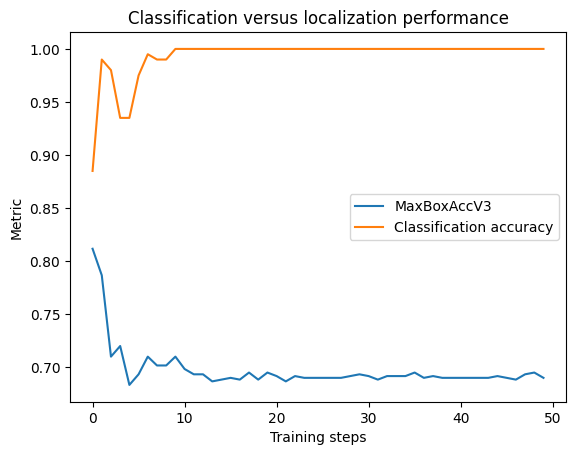

In [126]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

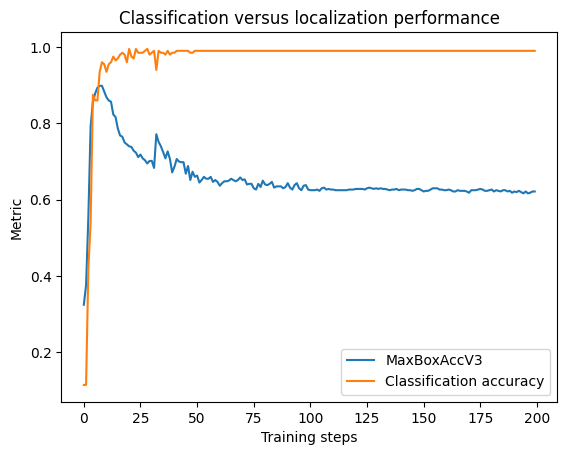

In [129]:
plt.plot(steps, val_maxboxaccv3, label = 'MaxBoxAccV3')
plt.plot(steps, val_accuracy, label='Classification accuracy')
plt.xlabel("Training steps")
plt.ylabel("Metric")
plt.title('Classification versus localization performance')
plt.legend()
plt.show()

In [133]:
iou_thresholds = [30, 50, 70]
iou_boxacc, _ = get_mlflow_boxacc_prcurve(experiment_name=experiment_name,dataset=dataset, spec=spec, archtype=archtype)

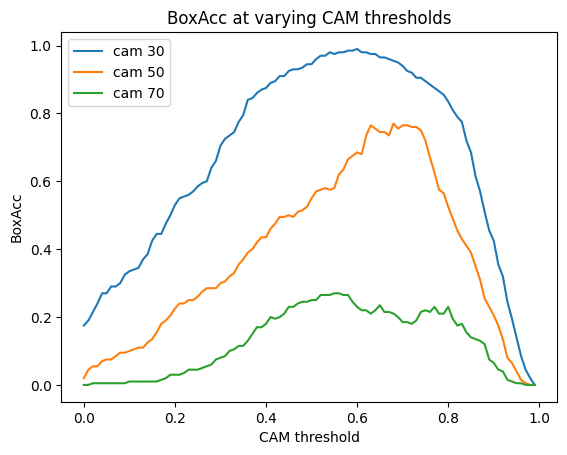

In [140]:
for method, iou_values in iou_boxacc.items():
    for iou_threshold, boxacc in iou_values.items():
        label = f'{method} {iou_threshold}'
        plt.plot(boxacc['cam_threshold'], boxacc['box_accuracy'], label = label)
plt.xlabel("CAM threshold")
plt.ylabel("BoxAcc")
plt.title('BoxAcc at varying CAM thresholds')
plt.legend()
plt.show()

In [152]:
xdef normalize_scoremap(cam):
    """
    Args:
        cam: numpy.ndarray(size=(H, W), dtype=np.float)
    Returns:
        numpy.ndarray(size=(H, W), dtype=np.float) between 0 and 1.
        If input array is constant, a zero-array is returned.
    """
    if np.isnan(cam).any():
        return np.zeros_like(cam)
    if cam.min() == cam.max():
        return np.zeros_like(cam)
    cam -= cam.min()
    cam /= cam.max()
    return cam

In [180]:
import numpy as np
import cv2

path_scoremap = '../val_log/vgg16_gap_cam_synthetic_d2b/scoremaps/test/SYNTHETIC_d_2_b_test_111.png.npy'
path_gtmask = '../data/maskdata/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_image = '../data/dataset/SYNTHETIC/d_2_b/test/SYNTHETIC_d_2_b_test_111.png'
path_overlay = 'overlay.png'

image_shape = (512, 512, 3)
img = cv2.imread(path_image) # color channels in BGR format
scoremap = np.load(path_scoremap)
cam = cv2.resize(scoremap, image_shape[:2], interpolation=cv2.INTER_CUBIC)
cam = normalize_scoremap(cam)
cam_threshold_optimal = 0.74
cam_mask = cam >= cam_threshold_optimal

In [182]:
segment_cam = np.zeros(shape=image_shape)
segment_cam[cam_mask] = (0, 0, 255)  # BGR
segment_gt = np.zeros(shape=image_shape)
segment_gt_image = cv2.imread(path_gtmask) # color channels in BGR format
gt_mask = segment_gt_image > 0
segment_gt[gt_mask[:,:,0]] = (0, 255, 0)
image = segment_gt * 0.3 + segment_cam * 0.3 + img * 0.4
cv2.imwrite(path_overlay, image)

True